In [13]:
from math import inf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import networkx as nx

rc('animation', html='jshtml')
rc('text', usetex=True)


class Dijkstra:
    def __init__(self, gr):
        self.fig = plt.figure()
        plt.axis('off')
        self.gr = gr
        pos = nx.planar_layout(self.gr)
        self.nodes = nx.draw_networkx_nodes(self.gr, pos, node_size=400)
        self.edges = nx.draw_networkx_edges(self.gr, pos)
        self.node_labels = nx.draw_networkx_labels(self.gr, pos)
        self.edge_labels = nx.get_edge_attributes(self.gr, 'weight')
        nx.draw_networkx_edge_labels(
            self.gr, pos, edge_labels=self.edge_labels)
        self.title = plt.title('')
        self.title.set_fontname('Comic Sans MS')

    def get_color(self, s):
        if s == self.min_dist_sommet:
            return 'g'
        if s in self.voisins:
            return 'c'
        if s in self.sommets_non_traites:
            return 'r'
        return 'y'

    def get_label(self, s):
        label = r"$"+s+"_{"
        label += "\infty" if self.dist[s] == inf else str(self.dist[s])
        label += "}$"
        return label

    def draw(self):
        self.title.set_text(self.text)
        self.nodes.set(color=[self.get_color(s) for s in self.gr.nodes])
        for s in self.node_labels:
            self.node_labels[s].set_text(self.get_label(s))
        yield

    def dijkstra(self, sommet_initial):
        self.sommet_initial = sommet_initial
        self.dist = {s: inf for s in self.gr.nodes}
        self.dist[sommet_initial] = 0
        self.sommets_non_traites = {s for s in self.gr.nodes}
        self.min_dist_sommet = None
        self.voisins = []
        self.text = 'Calcul des distances minimales à partir de '+self.sommet_initial
        yield from self.draw()
        while len(self.sommets_non_traites) != 0:
            min_dist = inf
            for s in self.sommets_non_traites:
                if self.dist[s] < min_dist:
                    self.min_dist_sommet = s
                    min_dist = self.dist[s]
            self.text = 'Le plus proche voisin non traité de ' + \
                self.sommet_initial+' est '+self.min_dist_sommet
            yield from self.draw()
            self.sommets_non_traites.remove(self.min_dist_sommet)
            self.voisins = {s: self.gr[self.min_dist_sommet][s] for s in self.gr[self.min_dist_sommet]
                            if s in self.sommets_non_traites}
            for s in self.voisins:
                d = min_dist+self.voisins[s]['weight']
                self.dist[s] = min(self.dist[s], d)
            self.text = 'Mise à jour des distances des voisins non traités de ' + self.min_dist_sommet if len(
                self.voisins) > 0 else self.min_dist_sommet+' ne possède pas de voisin non traité'
            yield from self.draw()
            self.text = 'Le sommet '+self.min_dist_sommet+' est marqué comme traité'
            self.min_dist_sommet = None
            self.voisins = []
            yield from self.draw()
        self.text = ''
        yield from self.draw()

    def animate(self, i):
        pass

    def get_dijkstra_animation(self, sommet_initial):
        ani = FuncAnimation(
            self.fig, self.animate, frames=lambda: self.dijkstra(sommet_initial), save_count=3*len(self.gr.nodes)+2, interval=2000)
        plt.close()
        return ani


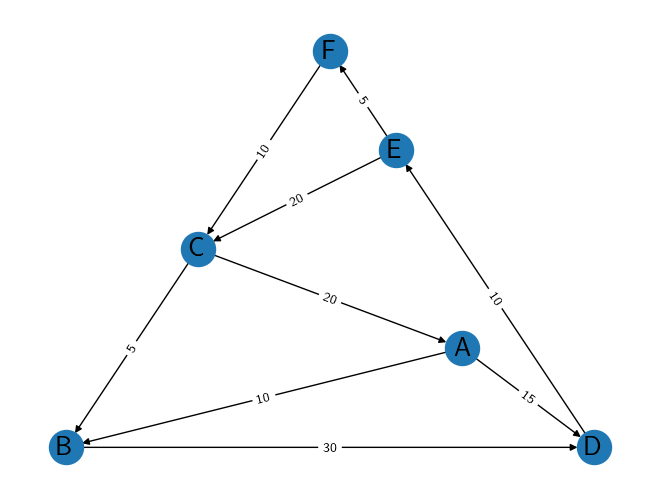

In [9]:
weighted_edges = [('A', 'B', 10), ('C', 'A', 20), ('C', 'B', 5),
                  ('A', 'D', 15), ('B', 'D', 30), ('E', 'C', 20),
                  ('D', 'E', 10), ('F', 'C', 10), ('E', 'F', 5)]
G = nx.DiGraph()
G.add_weighted_edges_from(weighted_edges)
labels = nx.get_edge_attributes(G,'weight')
pos = nx.planar_layout(G)
nx.draw(G, pos=pos, with_labels=True, font_weight="bold", font_size=20, node_size=600)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
plt.show()


In [14]:
Dijkstra(G).get_dijkstra_animation('A')


In [22]:
from matplotlib import rc
from matplotlib.pyplot import gca, figure, axis, close, Rectangle
from matplotlib.animation import FuncAnimation
from numpy import array

rc('animation', html='jshtml')


class TriBulles:
    def __init__(self, tab):
        N = len(tab)
        self.tab = tab.copy()
        self.width = 10

        self.fig = figure(figsize=(len(self.tab), 3))
        axis('off')
        axis('equal')
        axis([0, len(self.tab) * self.width, 0, self.width])

        self.rectangles = [gca().add_patch(Rectangle(array([i*self.width, 0]), self.width-1, self.width-1, fc='b'))
                           for i in range(N)]
        self.annotations = [gca().annotate(self.tab[i], array([i*self.width, 0])+array([(self.width-1)*.5, (self.width-1)*.5]), color='w',
                                           weight='bold', fontsize=20,
                                           ha='center',
                                           va='center') for i in range(N)]
        self.indices = [n for n in range(N)]

    def move_vertical(self, i, j):
        for _ in range(self.width):
            self.rectangles[i].set_xy(
                array(self.rectangles[i].get_xy())-array([0, 1]))
            self.annotations[i].set_position(
                array(self.annotations[i].get_position())-array([0, 1]))
            self.rectangles[j].set_xy(
                array(self.rectangles[j].get_xy())+array([0, 1]))
            self.annotations[j].set_position(
                array(self.annotations[j].get_position())+array([0, 1]))
            yield

    def move_horizontal(self, i, j):
        for _ in range(self.width):
            self.rectangles[i].set_xy(
                array(self.rectangles[i].get_xy())+array([1, 0]))
            self.annotations[i].set_position(
                array(self.annotations[i].get_position())+array([1, 0]))
            self.rectangles[j].set_xy(
                array(self.rectangles[j].get_xy())-array([1, 0]))
            self.annotations[j].set_position(
                array(self.annotations[j].get_position())-array([1, 0]))
            yield

    def set_color(self, i, j, color):
        self.rectangles[i].set_color(color)
        self.rectangles[j].set_color(color)
        yield

    def freeze_color(self, i, color):
        self.rectangles[i].set_color(color)
        yield

    def tri(self):
        n = len(self.tab)
        yield
        for i in reversed(range(n)):
            for j in range(i):
                if self.tab[j+1] < self.tab[j]:
                    yield from self.set_color(self.indices[j], self.indices[j+1], 'r')
                    yield from self.move_vertical(self.indices[j], self.indices[j+1])
                    yield from self.move_horizontal(self.indices[j], self.indices[j+1])
                    yield from self.move_vertical(self.indices[j+1], self.indices[j])
                    yield from self.set_color(self.indices[j], self.indices[j+1], 'b')
                    self.tab[j], self.tab[j+1] = self.tab[j+1], self.tab[j]
                    self.indices[j], self.indices[j +
                                                  1] = self.indices[j+1], self.indices[j]
                else:
                    yield from self.set_color(self.indices[j], self.indices[j+1], 'y')
                    for _ in range(self.width):
                        yield
                    yield from self.set_color(self.indices[j], self.indices[j+1], 'b')
            yield from self.freeze_color(self.indices[i], 'g')
            for _ in range(self.width):
                yield

    def animate(self, i):
        pass

    def get_animation(self):
        N = len(self.tab)
        ani = FuncAnimation(self.fig, self.animate, frames=self.tri,
                            save_count=N*(N-1)//2*self.width*5)
        close()
        return ani


In [23]:
from numpy.random import permutation
TriBulles(permutation(10)).get_animation()
